In [1]:
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [2]:
df = pd.read_csv('./spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
df['spam'] = df.Category.apply(lambda x: 1 if x == 'spam' else 0)

In [7]:
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [12]:
df1 = df[df.spam == 1]
df0 = df[df.spam == 0]

In [13]:
df1.shape

(747, 3)

In [14]:
df0.shape

(4825, 3)

In [15]:
df.shape

(5572, 3)

In [16]:
df0_undersampled = df0.sample(df1.shape[0])

In [17]:
df0_undersampled.shape

(747, 3)

In [18]:
df_balanced = pd.concat([df0_undersampled, df1])

In [19]:
df_balanced.shape

(1494, 3)

In [20]:
df_balanced.head()

,Category,Message,spam
2147,ham,So can collect ur laptop?,0
3042,ham,Aight what time you want me to come up?,0
3509,ham,"Camera quite good, 10.1mega pixels, 3optical a...",0
4422,ham,Still at west coast... Haiz... Ü'll take forev...,0
1038,ham,"naughty little thought: 'its better to flirt, ...",0


In [25]:
x = df_balanced.drop(['Category', 'spam'], axis = 'columns')
y = df_balanced.spam

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

In [27]:
x_train.shape

(1195, 1)

In [28]:
x_test.shape

(299, 1)

In [29]:
y_train[:10]

4647    1
312     1
1594    1
3125    0
2580    0
3897    1
2074    1
1044    0
4124    0
2170    1
Name: spam, dtype: int64

In [30]:
y_test[:10]

3639    1
415     1
5537    1
3377    0
4968    1
4442    0
3483    1
3460    1
5088    0
2978    0
Name: spam, dtype: int64

In [31]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [32]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [33]:
get_sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132726 , -0.8884572 , ..., -0.74748856,
        -0.7531473 ,  0.91964483],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.8584752 ,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

In [34]:
e = get_sentence_embedding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras
import tensorflow as tf

In [37]:
cosine_similarity([e[0]], [e[1]])

array([[0.9911088]], dtype=float32)

In [38]:
cosine_similarity([e[0]], [e[2]])

array([[0.99540985]], dtype=float32)

In [39]:
cosine_similarity([e[0]], [e[3]])

array([[0.8470383]], dtype=float32)

In [40]:
cosine_similarity([e[3]], [e[4]])

array([[0.98720354]], dtype=float32)

In [44]:
# Bert layers
text_input = keras.layers.Input(shape = (), dtype=tf.string, name = 'text')
preprocessed_text = bert_preprocess(text_input)
bert_output = bert_encoder(preprocessed_text)

# Neural 
dropout_layer = keras.layers.Dropout(0.1, name = 'dropout')(bert_output['pooled_output'])
final_layer = keras.layers.Dense(1, activation = 'sigmoid')(dropout_layer)

In [47]:
model = keras.Model(inputs = [text_input], outputs = [final_layer])

In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [49]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [50]:
x_train.shape

(1195, 1)

In [51]:
x_test.shape

(299, 1)

In [52]:
y_train.shape

(1195,)

In [53]:
y_test.shape

(299,)

In [54]:
model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
38/38 [==============================] - 373s 9s/step - loss: 0.6822 - accuracy: 0.5833
Epoch 2/10
38/38 [==============================] - 332s 9s/step - loss: 0.5427 - accuracy: 0.7816
Epoch 3/10
38/38 [==============================] - 338s 9s/step - loss: 0.4591 - accuracy: 0.8368
Epoch 4/10
38/38 [==============================] - 337s 9s/step - loss: 0.4055 - accuracy: 0.8711
Epoch 5/10
38/38 [==============================] - 343s 9s/step - loss: 0.3737 - accuracy: 0.8770
Epoch 6/10
38/38 [==============================] - 340s 9s/step - loss: 0.3495 - accuracy: 0.8862
Epoch 7/10
38/38 [==============================] - 341s 9s/step - loss: 0.3306 - accuracy: 0.8996
Epoch 8/10
38/38 [==============================] - 339s 9s/step - loss: 0.3194 - accuracy: 0.8862
Epoch 9/10
38/38 [==============================] - 342s 9s/step - loss: 0.3086 - accuracy: 0.8954
Epoch 10/10
38/38 [==============================] - 334s 9s/step - loss: 0.2897 - accuracy: 0.9071


In [55]:
model.evaluate(x_test, y_test)

10/10 [==============================] - 97s 9s/step - loss: 0.2275 - accuracy: 0.9431


[0.22753559052944183, 0.9431437849998474]

In [56]:
y_pred = model.predict(x_test)

10/10 [==============================] - 86s 8s/step


In [57]:
y_pred

array([[0.9109254 ],
       [0.7636212 ],
       [0.64167243],
       [0.5309641 ],
       [0.9440313 ],
       [0.02360577],
       [0.8360993 ],
       [0.26306805],
       [0.00987004],
       [0.10198779],
       [0.01170223],
       [0.34958372],
       [0.13501634],
       [0.64051586],
       [0.6842699 ],
       [0.03687376],
       [0.13614826],
       [0.90100324],
       [0.7244689 ],
       [0.5497174 ],
       [0.8737222 ],
       [0.51650167],
       [0.15737475],
       [0.22922991],
       [0.20791389],
       [0.29461342],
       [0.35348433],
       [0.94028866],
       [0.68769157],
       [0.20315291],
       [0.8427634 ],
       [0.07415866],
       [0.03817262],
       [0.02634753],
       [0.2059592 ],
       [0.3432991 ],
       [0.11469635],
       [0.93292725],
       [0.9316081 ],
       [0.3507216 ],
       [0.59050584],
       [0.14587736],
       [0.80897725],
       [0.07575789],
       [0.1398792 ],
       [0.7795116 ],
       [0.10393011],
       [0.020

In [66]:
import numpy as np
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

In [67]:
y_pred[:5]

array([1, 1, 1, 1, 1])

In [68]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cm

array([[138,  11],
       [  6, 144]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

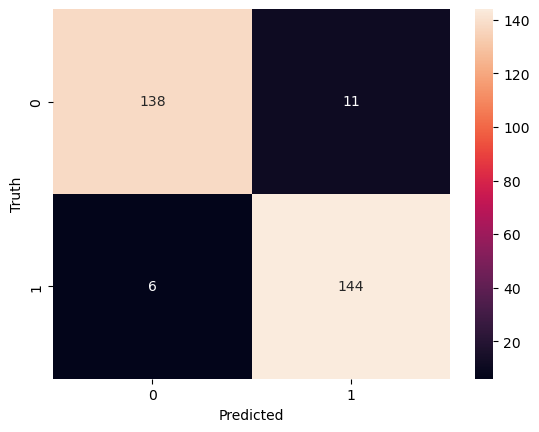

In [69]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       149
           1       0.93      0.96      0.94       150

    accuracy                           0.94       299
   macro avg       0.94      0.94      0.94       299
weighted avg       0.94      0.94      0.94       299



In [71]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.71398926],
       [0.8196153 ],
       [0.737107  ],
       [0.21245362],
       [0.11548032]], dtype=float32)